# Developing a Weather Chatbot with Natural Language Processing Capability

## Create Webhook (private)

In [4]:
from flask import Flask, request

app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>Hello World</h1>"

@app.route("/webhook", methods=['POST'])
def webhook():
    req = request.get_json()
    print(req)
    reText = req['queryResult']['fulfillmentText']   # 取得回覆文字
    print(reText)
    return {
          "fulfillmentText": f'{reText} ( webhook )',
          "source": "webhookdata"
      }

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Jan/2024 13:07:34] "POST /webhook HTTP/1.1" 200 -


{'responseId': 'bc386310-8c3b-40aa-b745-fbc487d1da0c-d5f6109d', 'queryResult': {'queryText': '嗨', 'action': 'input.welcome', 'parameters': {'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '你好！', 'fulfillmentMessages': [{'text': {'text': ['你好！']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2bf84373-5fe1-02f1-f275-1818ec06ccb7/contexts/__system_counters__', 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/8f499471-b826-41af-9391-7e9b9c3c448c', 'displayName': 'Default Welcome Intent'}, 'intentDetectionConfidence': 1.0, 'languageCode': 'zh-tw', 'sentimentAnalysisResult': {'queryTextSentiment': {'score': 0.4, 'magnitude': 0.4}}}, 'originalDetectIntentRequest': {'source': 'DIALOGFLOW_CONSOLE', 'payload': {}}, 'session': 'projects/ai9527-project-aeql/agent/sessions/2bf84373-5fe1-02f1-f275-1818ec06ccb7'}
你好！


127.0.0.1 - - [15/Jan/2024 13:08:06] "POST /webhook HTTP/1.1" 200 -


{'responseId': '5fa011f2-b844-4bbe-8d97-e48413985cc7-d5f6109d', 'queryResult': {'queryText': '哈囉', 'action': 'input.welcome', 'parameters': {'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '嘿！', 'fulfillmentMessages': [{'text': {'text': ['嘿！']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2261e8ec-390b-3c8a-96d4-51b000190c38/contexts/__system_counters__', 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/8f499471-b826-41af-9391-7e9b9c3c448c', 'displayName': 'Default Welcome Intent'}, 'intentDetectionConfidence': 1.0, 'languageCode': 'zh-tw'}, 'originalDetectIntentRequest': {'source': 'line', 'payload': {'data': {'source': {'type': 'user', 'userId': 'U5118169534cb5dc073b0c8e3f7ee5751'}, 'type': 'message', 'replyToken': '2612453fd3b742c49cd2f0213884cb73', 'message': {'id': '490673135764111573', 'text': '哈囉', 'type': 'text'}, 'times

127.0.0.1 - - [15/Jan/2024 13:08:13] "POST /webhook HTTP/1.1" 200 -


{'responseId': 'a2cac9bb-8d4b-4e0d-a014-dd0d20f59b58-d5f6109d', 'queryResult': {'queryText': '你好', 'action': 'input.welcome', 'parameters': {'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '嘿！ 好久不見！', 'fulfillmentMessages': [{'text': {'text': ['嘿！ 好久不見！']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2261e8ec-390b-3c8a-96d4-51b000190c38/contexts/__system_counters__', 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/8f499471-b826-41af-9391-7e9b9c3c448c', 'displayName': 'Default Welcome Intent'}, 'intentDetectionConfidence': 1.0, 'languageCode': 'zh-tw'}, 'originalDetectIntentRequest': {'source': 'line', 'payload': {'data': {'timestamp': '1705295291137', 'replyToken': 'ab726940bef441a3a1ecb2b75840096e', 'message': {'id': '490673148363014258', 'text': '你好', 'type': 'text'}, 'source': {'userId': 'U5118169534cb5dc073b0c8e3f7ee5751', 

The messages received by the webhook above are from Dialogflow, and the displayed reply message `reText` is also selected by Dialogflow through **intent** analysis to determine the response sentence.

## Integrating with Radar Chart
While receiving a message related to a radar chart::
1. The message will be sent to our private webhook through Dialogflow
2. We determine whether this message belongs to the **radar** intent we established in Dialogflow.
3. If True, we utilize a proprietary method along with requests, coupled with the Reply Token, to directly communicate with LINE and send back the radar chart image.
4. **Note that since the Reply Token can only be used once, after sending the image, further messages cannot be transmitted through Dialogflow.**

In [2]:
from flask import Flask, request
import requests, json
from datetime import datetime, timedelta
from dotenv import dotenv_values

In [9]:
# LINE 回傳圖片函式
def reply_image(msg, rk, token):
    headers = {'Authorization':f'Bearer {token}','Content-Type':'application/json'}    
    body = {
    'replyToken':rk,
    'messages':[{
          'type': 'image',
          'originalContentUrl': msg,
          'previewImageUrl': msg
        }]
    }
    req = requests.request('POST', 'https://api.line.me/v2/bot/message/reply', headers=headers, data=json.dumps(body).encode('utf-8'))
    print(req.text)

# LINE 回傳訊息函式
def reply_message(msg, rk, token):
    headers = {'Authorization':f'Bearer {token}','Content-Type':'application/json'}
    body = {
    'replyToken':rk,
    'messages':[{
            "type": "text",
            "text": msg
        }]
    }
    req = requests.request('POST', 'https://api.line.me/v2/bot/message/reply', headers=headers, data=json.dumps(body).encode('utf-8'))
    print(req.text)

# LINE push 訊息函式
def push_message(msg, uid, token):
    headers = {'Authorization':f'Bearer {token}','Content-Type':'application/json'}   
    body = {
    'to':uid,
    'messages':[{
            "type": "text",
            "text": msg
        }]
    }
    req = requests.request('POST', 'https://api.line.me/v2/bot/message/push', headers=headers,data=json.dumps(body).encode('utf-8'))
    print(req.text)

In [7]:
access_token = dotenv_values('.env')['LINE_ACCESS_TOKEN']
channel_secret = dotenv_values('.env')['LINE_CHANELL_SECRET']

In [7]:
app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>Hello World</h1>"

@app.route("/webhook", methods=['POST'])
def webhook():
    req = request.get_json()
    print(req)
    reText = req['queryResult']['fulfillmentText'] # 取得回覆文字
    intent = req['queryResult']['intent']['displayName'] # 取得 intent 分類
    reply_token = req['originalDetectIntentRequest']['payload']['data']['replyToken']  # 取得 LINE replyToken

    # 待傳送雷達回波圖網址(加上時間戳記)
    current_time = datetime.now()
    one_hour_ago = current_time - timedelta(hours=1)
    rounded_time = one_hour_ago.replace(minute=0, second=0, microsecond=0)
    formatted_time = rounded_time.strftime("%Y%m%d%H%M")
    img = f"https://www.cwa.gov.tw/Data/radar/CV1_3600_{formatted_time}.png"

    # 若該則訊息的 intent 為 radar
    if intent=="radar":
        reply_image(img, reply_token, access_token) # 通過 requests 方法直接回傳訊息
        return {
            "source": "webhookdata"
        }
    else: # 若該則訊息的 intent 不為 ra
        return {
            "fulfillmentText": f'{reText} ( webhook )',
            "source": "webhookdata"
        }

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


{'responseId': '3b7e266d-5cac-4760-a2e9-6de4905139c6-d5f6109d', 'queryResult': {'queryText': '雷達圖', 'parameters': {'person': '', 'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '請稍等我一下~', 'fulfillmentMessages': [{'text': {'text': ['請稍等我一下~']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2261e8ec-390b-3c8a-96d4-51b000190c38/contexts/__system_counters__', 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'person': '', 'person.original': '', 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/01e01a72-28cd-4de2-bbe3-d58752dd385f', 'displayName': 'radar'}, 'intentDetectionConfidence': 1.0, 'languageCode': 'zh-tw'}, 'originalDetectIntentRequest': {'source': 'line', 'payload': {'data': {'source': {'type': 'user', 'userId': 'U5118169534cb5dc073b0c8e3f7ee5751'}, 'type': 'message', 'message': {'id': '490676016109584995', 'type': 'text', 'text': '雷達圖'}, 'replyToken': '0df1378eb511441cbf0e39

127.0.0.1 - - [15/Jan/2024 13:36:44] "POST /webhook HTTP/1.1" 200 -


{"sentMessages":[{"id":"490676020572324007","quoteToken":"7zU3QAT-Im9OdJcOonJq5FasMitXqFd4BqwEUg6-9CdkZKocgiqfxFrMn-l11WKsS-NNFSu_usjdOXmG51xRqNn-nG9MQOwMYA8VscKTkQgmiekz9EOCikfBy83U_CzBiliofQV4G8ckwAdk1cRAVw"}]}


127.0.0.1 - - [15/Jan/2024 13:37:00] "POST /webhook HTTP/1.1" 200 -


{'responseId': 'dc9c7a78-5768-474b-8cbb-e8b093fa1da7-d5f6109d', 'queryResult': {'queryText': '你好啊', 'action': 'input.welcome', 'parameters': {'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '你好！', 'fulfillmentMessages': [{'text': {'text': ['你好！']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2261e8ec-390b-3c8a-96d4-51b000190c38/contexts/__system_counters__', 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/8f499471-b826-41af-9391-7e9b9c3c448c', 'displayName': 'Default Welcome Intent'}, 'intentDetectionConfidence': 1.0, 'languageCode': 'zh-tw'}, 'originalDetectIntentRequest': {'source': 'line', 'payload': {'data': {'message': {'text': '你好啊', 'type': 'text', 'id': '490676045637747171'}, 'source': {'userId': 'U5118169534cb5dc073b0c8e3f7ee5751', 'type': 'user'}, 'timestamp': '1705297018199', 'type': 'message', 'replyToken': 'a2233f5

Testing:

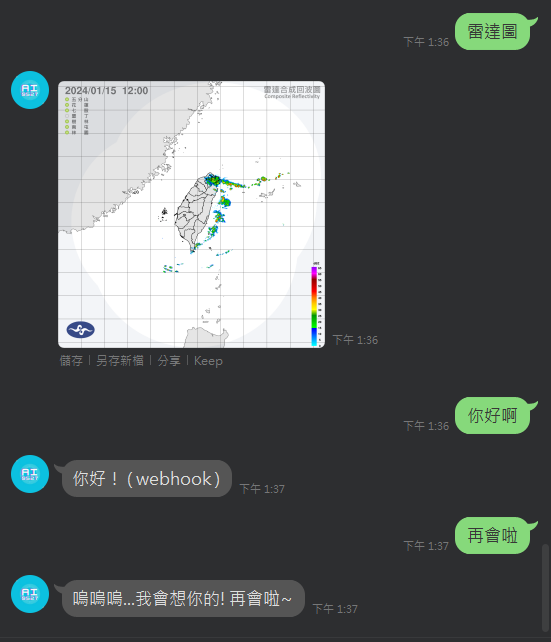

- The first radar chart message is directly returned through our own server.
- The second greeting message is transmitted through Dialogflow + our private server, using Dialogflow's webhook for the response (labeled with a webhook suffix).
- The third exit message is determined and returned by Dialogflow based on semantic analysis.

---

# Integrating with OpenAI ChatGPT (Creating a Genuine AI Chatbot)"

In [3]:
from openai import OpenAI
import openai
client = OpenAI(api_key=dotenv_values('.env')['OPENAI_API_KEY'])

## Retrieve Weather Data through Web Scraping

In [4]:
def get_weather_descript(loc): 
    url = 'https://opendata.cwa.gov.tw/fileapi/v1/opendataapi/F-C0032-001?Authorization=CWA-A01BA71F-E09F-408F-988C-1BB341F15D41&downloadType=WEB&format=JSON'
    data = requests.get(url)
    data_json = data.json()
    weather_descript = ''
    for location in data_json['cwaopendata']['dataset']['location']:
        city = location['locationName']
        if city == loc:
            wx8 = location['weatherElement'][0]['time'][0]['parameter']['parameterName']
            maxt8 = location['weatherElement'][1]['time'][0]['parameter']['parameterName']
            mint8 = location['weatherElement'][2]['time'][0]['parameter']['parameterName']
            ci8 = location['weatherElement'][3]['time'][0]['parameter']['parameterName']
            pop8 = location['weatherElement'][4]['time'][0]['parameter']['parameterName']
            weather_descript = f'{city}未來 8 小時{wx8}, 最高溫 {maxt8} 度, 最低溫 {mint8} 度, 降雨機率 {pop8}%, 整體感受{ci8}'
    #print(weather_descript)
    return str(weather_descript)

In [11]:
app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>Hello World</h1>"

test = ''

@app.route("/webhook", methods=['POST'])
def webhook():
    req = request.get_json()
    print(req)
    
    intent = req['queryResult']['intent']['displayName'] # 取得 intent 分類
    reply_token = req['originalDetectIntentRequest']['payload']['data']['replyToken']  # 取得 LINE replyToken

    # 待傳送雷達回波圖網址(加上時間戳記)
    current_time = datetime.now()
    one_hour_ago = current_time - timedelta(hours=1)
    rounded_time = one_hour_ago.replace(minute=0, second=0, microsecond=0)
    formatted_time = rounded_time.strftime("%Y%m%d%H%M")
    img = f"https://www.cwa.gov.tw/Data/radar/CV1_3600_{formatted_time}.png"

    # 若該則訊息的 intent 為 radar
    if intent=="radar":
        reply_image(img, reply_token, access_token) # 通過 requests 方法直接回傳訊息
        return {
            "source": "webhookdata"
        }
    
    # 通過 ChatGPT 報告天氣概況
    elif intent=="weather_summary": 
        city = req['queryResult']['queryText']
        msg = get_weather_descript(city) + '\n請根據以上資訊提醒'
        response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages= [
                    {"role": "system", "content": "你是一名氣象助理"},
                    {"role": "user", "content": msg},
                ],
                max_tokens=200,
                temperature=0.5,
                )
        reply_msg = response.choices[0].message.content
        reply_message(reply_msg, reply_token, access_token)
        return {
            "source": "webhookdata"
        }

    # 若該則訊息的 intent 不為天氣相關
    else: 
        reText = req['queryResult']['fulfillmentText'] # 取得回覆文字
        return {
            "fulfillmentText": f'{reText}',
            "source": "webhookdata"
        }

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Jan/2024 21:50:05] "POST /webhook HTTP/1.1" 200 -


{'responseId': 'fe5a79b1-ee36-4333-829f-dadd274db9f1-d5f6109d', 'queryResult': {'queryText': '您好~', 'action': 'input.welcome', 'parameters': {'location': ''}, 'allRequiredParamsPresent': True, 'fulfillmentText': '嘿！歡迎你回來。', 'fulfillmentMessages': [{'text': {'text': ['嘿！歡迎你回來。']}}], 'outputContexts': [{'name': 'projects/ai9527-project-aeql/agent/sessions/2261e8ec-390b-3c8a-96d4-51b000190c38/contexts/__system_counters__', 'lifespanCount': 1, 'parameters': {'no-input': 0.0, 'no-match': 0.0, 'location': '', 'location.original': ''}}], 'intent': {'name': 'projects/ai9527-project-aeql/agent/intents/8f499471-b826-41af-9391-7e9b9c3c448c', 'displayName': 'Default Welcome Intent'}, 'intentDetectionConfidence': 0.4457326, 'languageCode': 'zh-tw'}, 'originalDetectIntentRequest': {'source': 'line', 'payload': {'data': {'type': 'message', 'message': {'type': 'text', 'id': '490725682238718102', 'text': '您好~'}, 'timestamp': '1705326603789', 'source': {'userId': 'U5118169534cb5dc073b0c8e3f7ee5751', 'ty

127.0.0.1 - - [15/Jan/2024 21:50:42] "POST /webhook HTTP/1.1" 200 -


{"sentMessages":[{"id":"490725746009702898","quoteToken":"2R06D16gPmh49frlzzcPwKlfofzawYmFomgVaqJYjro_FR2rvcn4ctSNhixny-zwJll9sbzwYwECWhKlkJdD-U8F9SWL8zzdxO78rbwjU6xjG_0nb6RwwfUBzpo7f3elyFWqlVwoCIvlo87ACgNdxw"}]}


Final Result:

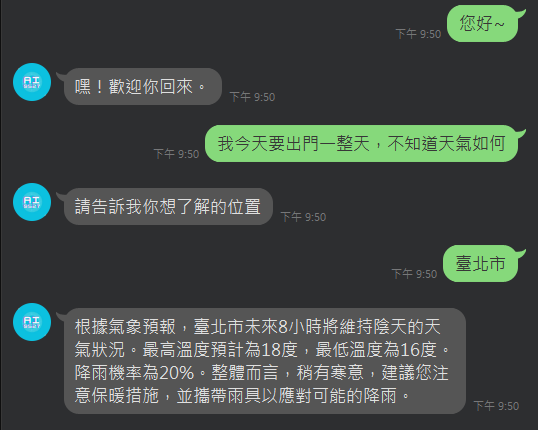